<a href="https://colab.research.google.com/github/Z4HRA-S/Solar_Panel_Object_Detection/blob/main/object_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read the Data

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/proactive/

/content/drive/MyDrive/Colab Notebooks/proactive


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import torchvision.transforms.functional as TF
import torch
from torchvision.ops import masks_to_boxes
import matplotlib.patches as patches

In [ ]:
def plot(image,label,box=None):
  image = image.transpose(0,2).transpose(0,1).detach().numpy()
  label = label.squeeze().detach().numpy()
  i, (im1) = plt.subplots(1,2)
  i.set_figwidth(5)
  im1[0].imshow(image)
  if box is not None:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    im1[0].add_patch(rect)

  im1[1].imshow(label)

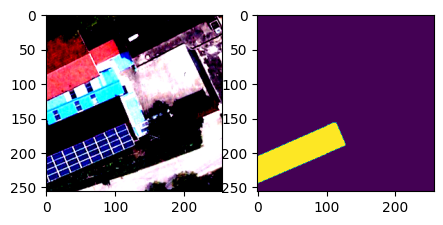

In [ ]:
img =TF.to_tensor(Image.open("processed_data/1.bmp"))
msk = TF.to_tensor(TF.to_grayscale(Image.open("processed_data/1_mask.bmp")))
plot(img,msk)

## Bounding Box
For the task of object detection, we need to convert the segmentation masks into bounding boxes, so we try the function from `torchvision`. The shortcoming of this method is that the bounding box will cover all panels at once, not every one of them separately.

At first, I wanted to consider all non-zero points which have a distance of 1 from each other as one object and group them. But the algorithm that I implemented was too slow and I had no time to correct it.

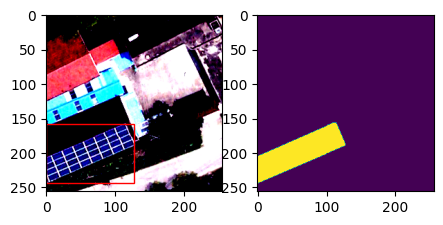

In [ ]:
boxes = masks_to_boxes(msk)
plot(img,msk,box = boxes[0])

#Define the Dataset

For this task, I read a [tutorial on the Pytorch website](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and customized its codes based on my need. Here I have defined a dataset class for my data.

In [ ]:
import os

class PanelImage(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        self.imgs = [img for img in listdir(data_path) if not img.endswith("mask.bmp")]

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.imgs[idx])
        mask_path = os.path.join(self.data_path,  f"{self.imgs[idx][:-4]}_mask.bmp")
        img = Image.open(img_path).convert("RGB")

        masks = Image.open(mask_path)
        masks = TF.to_tensor(TF.to_grayscale((masks)))
        boxes = masks_to_boxes(masks) if torch.nonzero(masks).size()[0]>0 else torch.Tensor([[0,0,0,0]])

        # there is only one class
        labels = torch.ones((1,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
            #target = self.transforms(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision.transforms as T

def get_transform():
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    return T.Compose(transforms)

In [ ]:
import utils

data = PanelImage("processed_data", transforms=get_transform())

batch_size=10
len_train = 700
len_val= len(data) - len_train
train_set, val_set = torch.utils.data.random_split(data,[len_train, len_val])

data_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle=True, pin_memory=True,
                                          collate_fn = utils.collate_fn)

validation_data_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,
                                          shuffle=True,pin_memory=True,
                                          collate_fn = utils.collate_fn)

#Model Training

## Object Detection
The tutorial on the Pytorch website has loaded and fine-tuned the MaskRCNN model which produces both segment mask and bounding box as a result. It's fascinating!

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

###Explore the Model

First let's try the pre-trained model as-is. I want to see the structure of its output. I have downloaded an image from the net containing several people. The `maskRCNN` model is trained on the COCO dataset and one of this dataset's labels is "person" assigned with number 1 in the labels set.

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()
test_img = TF.to_tensor(Image.open("test_panel_data/test_person.jpg"))
output = model(test_img.unsqueeze(dim=0))
output[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [ ]:
print([(k,output[0][k].size()) for k in output[0].keys()])

[('boxes', torch.Size([100, 4])), ('labels', torch.Size([100])), ('scores', torch.Size([100])), ('masks', torch.Size([100, 1, 256, 256]))]


In [ ]:
output[0]["scores"]

tensor([0.9981, 0.9976, 0.9972, 0.9970, 0.9880, 0.9627, 0.9603, 0.9175, 0.8673,
        0.8666, 0.7573, 0.7174, 0.6875, 0.6561, 0.6168, 0.6002, 0.5069, 0.5036,
        0.4409, 0.4226, 0.3952, 0.3468, 0.3247, 0.3150, 0.3047, 0.2717, 0.2648,
        0.2633, 0.1707, 0.1663, 0.1526, 0.1436, 0.1421, 0.1412, 0.1376, 0.1131,
        0.1120, 0.0961, 0.0940, 0.0891, 0.0818, 0.0755, 0.0738, 0.0582, 0.0569,
        0.0569, 0.0565, 0.0537, 0.0512, 0.0511], grad_fn=<IndexBackward0>)

In [ ]:
output[0]["labels"]

tensor([ 1,  1,  1, 32, 32,  1, 32, 62,  1, 67, 62, 77, 49,  1,  1,  1, 67, 73,
         1, 75,  1,  1, 67, 84,  1, 77, 47,  1,  1, 32, 32, 31, 32,  1, 84,  1,
         1,  1,  1,  1, 62, 67, 84,  1, 63, 32,  1,  1,  1, 62])

______________
 Let's visualize the first 3 person (label 1) with the most score.

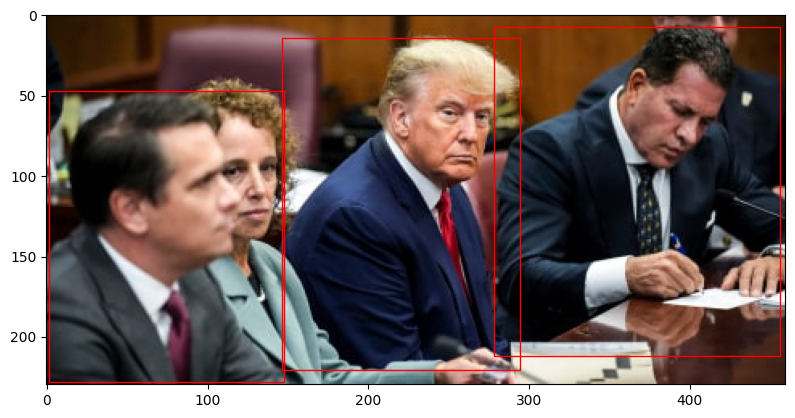

In [ ]:
image = test_img.transpose(0,2).transpose(0,1).detach().numpy()
i, im1 = plt.subplots(1)
i.set_figwidth(10)
im1.imshow(image)
box_list=output[0]["boxes"].detach().numpy()
for box in box_list[:3]:
  rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                            linewidth=1, edgecolor='r', facecolor='none')
  im1.add_patch(rect)

### Train and Finetune the Model

Time to teach this model to act on our data :)

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 30

model = get_model_instance_segmentation(2)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, validation_data_loader, device=device)

    model_state = model.state_dict()
    opt_state = optimizer.state_dict()
    torch.save({'model_state_dict': model_state,
                'optimizer_state_dict': opt_state,
              }, "saved_model/obj_det_w.pt")

Epoch: [0]  [ 0/70]  eta: 0:02:08  lr: 0.000077  loss: 0.9769 (0.9769)  loss_classifier: 0.7518 (0.7518)  loss_box_reg: 0.0924 (0.0924)  loss_mask: 0.0789 (0.0789)  loss_objectness: 0.0415 (0.0415)  loss_rpn_box_reg: 0.0123 (0.0123)  time: 1.8407  data: 0.0923  max mem: 10820
Epoch: [0]  [69/70]  eta: 0:00:01  lr: 0.005000  loss: 0.1684 (0.3163)  loss_classifier: 0.0485 (0.1299)  loss_box_reg: 0.0802 (0.0829)  loss_mask: 0.0000 (0.0082)  loss_objectness: 0.0218 (0.0649)  loss_rpn_box_reg: 0.0101 (0.0304)  time: 1.8793  data: 0.0865  max mem: 10989
Epoch: [0] Total time: 0:02:09 (1.8476 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.9266 (0.9266)  evaluator_time: 0.0447 (0.0447)  time: 1.0220  data: 0.0494  max mem: 10989
Test:  [3/4]  eta: 0:00:00  model_time: 0.8402 (0.7902)  evaluator_time: 0.0323 (0.0351)  time: 0.8710  data: 0.0444  max mem: 10989
Test: Total time: 0:00:03 (0.8714 s / it)
Averaged stats: model_time: 0.8402 (0.7902)  evaluator_tim



---


**So, for now we can go to the Evaluation notebook and see the result there.**